In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    # Hyperparameters
    num_classes = 100
    input_shape = (32, 32, 3)
    
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 100
    dropout_rate = 0.2
    image_size = 64  # We'll resize input images to this size.
    patch_size = 2  # Size of the patches to be extract from the input images.
    num_patches = (image_size // patch_size) ** 2  # Size of the data array.
    latent_dim = 256  # Size of the latent array.
    projection_dim = 256  # Embedding size of each element in the data and latent arrays.
    num_heads = 8  # Number of Transformer heads.
    ffn_units = [
        projection_dim,
        projection_dim,
    ]  # Size of the Transformer Feedforward network.
    num_transformer_blocks = 4
    num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
    classifier_units = [
        projection_dim,
        num_classes,
    ]  # Size of the Feedforward network of the final classifier.

In [2]:
import tensorflow_addons as tfa

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


# Prepare the data

In [6]:

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# Configure the hyperparameters

In [7]:
print(f"Image size: {CFG.image_size} X {CFG.image_size} = {CFG.image_size ** 2}")
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size} = {CFG.patch_size ** 2} ")
print(f"Patches per image: {CFG.num_patches}")
print(f"Elements per patch (3 channels): {(CFG.patch_size ** 2) * 3}")
print(f"Latent array shape: {CFG.latent_dim} X {CFG.projection_dim}")
print(f"Data array shape: {CFG.num_patches} X {CFG.projection_dim}")

Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12
Latent array shape: 256 X 256
Data array shape: 1024 X 256


# Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(CFG.image_size, CFG.image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement Feedforward network (FFN)

In [9]:
def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(tf.keras.layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(tf.keras.layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(tf.keras.layers.Dropout(dropout_rate))

    ffn = tf.keras.Sequential(ffn_layers)
    return ffn

# Implement patch creation as a layer

In [10]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Implement the patch encoding layer

In [11]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# Build the Perceiver model

In [12]:
def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": tf.keras.layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": tf.keras.layers.Input(shape=(data_dim, projection_dim)),
    }

    # Apply layer norm to the inputs
    latent_array = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = tf.keras.layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = tf.keras.layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = tf.keras.layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = tf.keras.layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = tf.keras.layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = tf.keras.layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Transformer module

In [13]:
def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = tf.keras.layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = tf.keras.layers.Add()([x3, x2])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=x0)
    return model

# Perceiver model

In [14]:
class Perceiver(tf.keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super().__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super().build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits

# Compile, train, and evaluate the mode

In [15]:
def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(
        learning_rate=CFG.learning_rate, weight_decay_rate=CFG.weight_decay,
    )

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Create a learning rate scheduler callback.
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # Fit the model.
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=CFG.batch_size,
        epochs=CFG.num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [16]:
perceiver_classifier = Perceiver(
    CFG.patch_size,
    CFG.num_patches,
    CFG.latent_dim,
    CFG.projection_dim,
    CFG.num_heads,
    CFG.num_transformer_blocks,
    CFG.ffn_units,
    CFG.dropout_rate,
    CFG.num_iterations,
    CFG.classifier_units,
)


history = run_experiment(perceiver_classifier)

Epoch 1/100
352/352 [==============================] - 130s 348ms/step - loss: 4.3422 - accuracy: 0.0494 - top-5-accuracy: 0.1743 - val_loss: 4.0600 - val_accuracy: 0.0836 - val_top-5-accuracy: 0.2534 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 122s 346ms/step - loss: 4.0594 - accuracy: 0.0900 - top-5-accuracy: 0.2648 - val_loss: 3.7965 - val_accuracy: 0.1206 - val_top-5-accuracy: 0.3396 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 122s 346ms/step - loss: 3.8666 - accuracy: 0.1211 - top-5-accuracy: 0.3231 - val_loss: 3.5721 - val_accuracy: 0.1596 - val_top-5-accuracy: 0.4014 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 122s 346ms/step - loss: 3.6980 - accuracy: 0.1506 - top-5-accuracy: 0.3764 - val_loss: 3.4072 - val_accuracy: 0.1798 - val_top-5-accuracy: 0.4558 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 122s 346ms/step - loss: 3.5253 - accuracy: 0.1820 - top-5-accuracy: 0.4242 - val_loss: 3.

352/352 [==============================] - 122s 346ms/step - loss: 1.5872 - accuracy: 0.6146 - top-5-accuracy: 0.8698 - val_loss: 1.9229 - val_accuracy: 0.5044 - val_top-5-accuracy: 0.7884 - lr: 4.0000e-05
Epoch 40/100
352/352 [==============================] - 122s 346ms/step - loss: 1.5877 - accuracy: 0.6124 - top-5-accuracy: 0.8696 - val_loss: 1.9233 - val_accuracy: 0.5104 - val_top-5-accuracy: 0.7898 - lr: 4.0000e-05
Epoch 41/100
352/352 [==============================] - 123s 348ms/step - loss: 1.5685 - accuracy: 0.6194 - top-5-accuracy: 0.8704 - val_loss: 1.9218 - val_accuracy: 0.5078 - val_top-5-accuracy: 0.7868 - lr: 8.0000e-06
Epoch 42/100
352/352 [==============================] - 122s 346ms/step - loss: 1.5635 - accuracy: 0.6194 - top-5-accuracy: 0.8710 - val_loss: 1.9220 - val_accuracy: 0.5080 - val_top-5-accuracy: 0.7862 - lr: 8.0000e-06
Epoch 43/100
352/352 [==============================] - 122s 346ms/step - loss: 1.5604 - accuracy: 0.6214 - top-5-accuracy: 0.8732 - val_

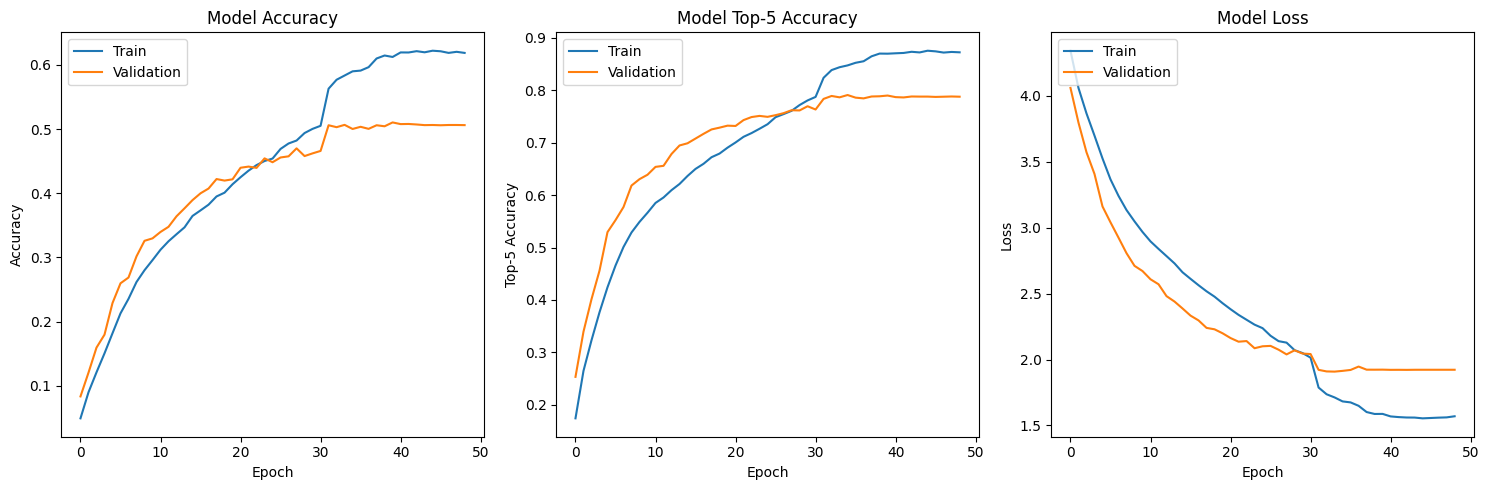

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

1/1 [==============================] - 0s 60ms/step


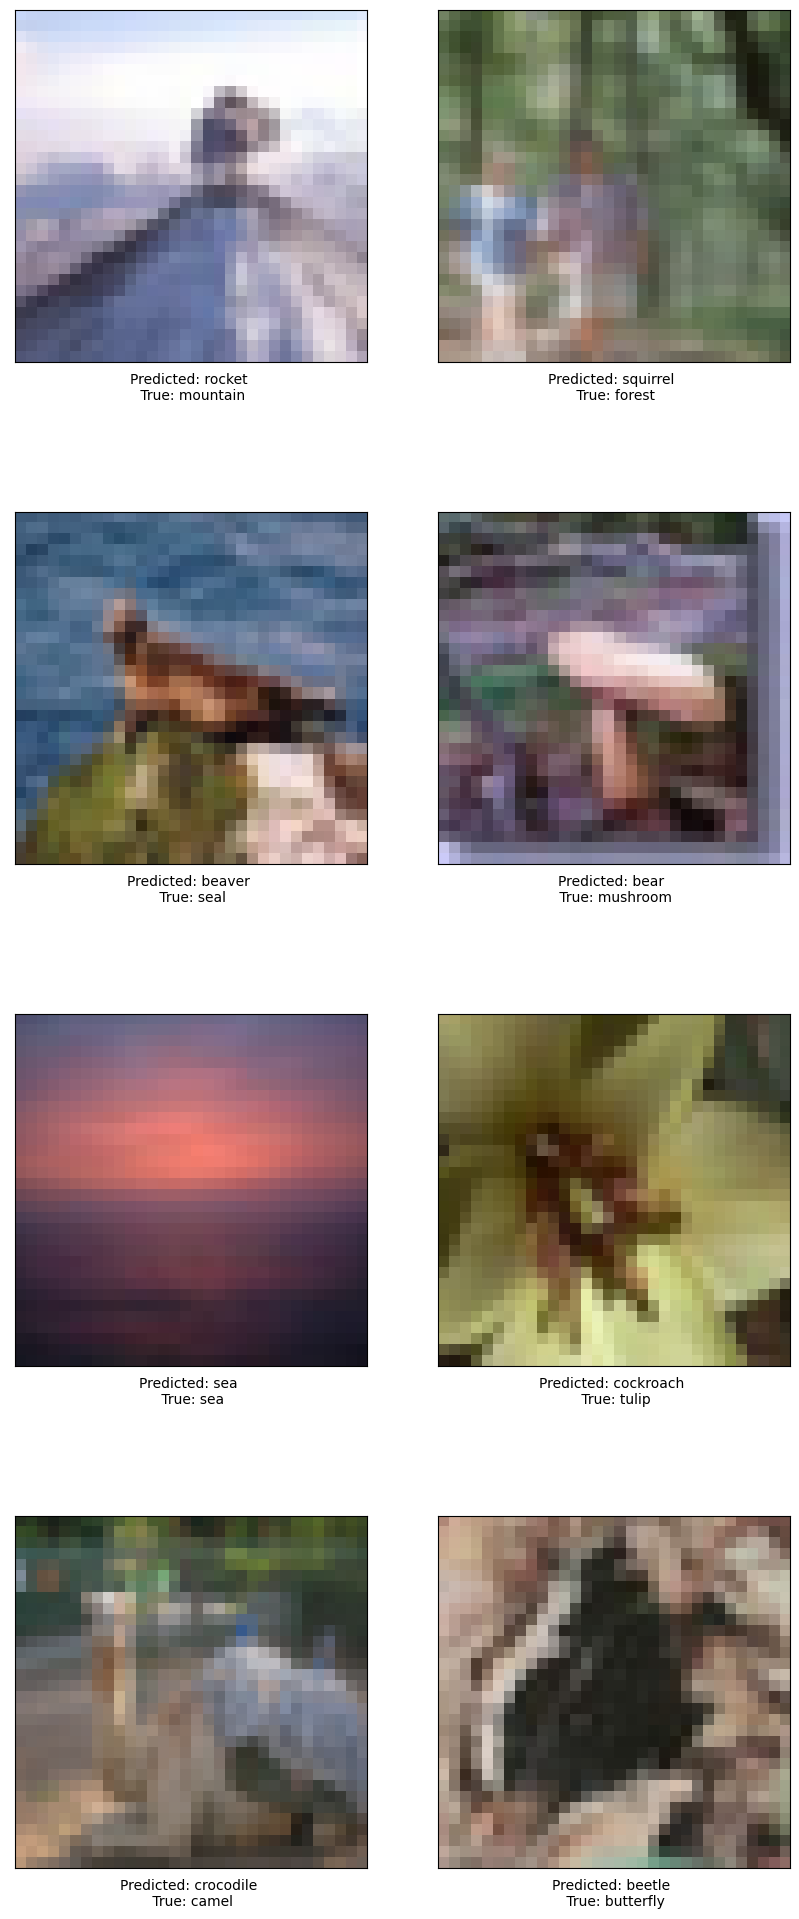

In [18]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)

    pred = history.model.predict(X_test[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = int(y_test[i])
    
    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label]}")
plt.show()